In [1]:
import pandas as pd
import numpy as np
import ast
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
plt.style.use("ggplot")

In [3]:
def combine_reviews(data, isPreprocessed=True):
    """Combine user reviews into an array
    
    Args:
        data (dataframe): contains user reviews as string representations of lists if preprocessed or
                          simply as strings otherwise
        isPreprocessed (bool): specifies whether or not the data has been preprocessed
    
    Returns:
        corpus (array): an array containing the tokenized reviews if preprocessed or each review as a
                        separate string otherwise
    """
    
    corpus = []
    if (isPreprocessed):
        reviews = data['review'].copy()
        reviews = reviews.apply(ast.literal_eval)
        concatenated_reviews = reviews.apply(' '.join)
        concatenated_reviews.apply(corpus.append)
    else:
        concatenated_reviews = data['review'].copy()
        concatenated_reviews = concatenated_reviews.astype(str)
        concatenated_reviews.apply(corpus.append)
    return corpus

def graph_word_cloud(corpus):
    """Graph a word cloud based on corpus
    
    Args:
        corpus (str): contains the text data
    
    Returns:
        None
    """
    
    word_cloud = WordCloud(width=1600, height=800, collocations=False).generate(corpus)
    plt.figure(figsize=(20,20))
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()
    
def stem_review(review):
    """Stem a single user review
    
    Args:
        review (string): a preprocessed review
    
    Returns:
        stemmed_review (string): preprocessed review which has been stemmed using PorterStemmer()                        
    """
    
    stemmer = PorterStemmer()
    stemmed_review = [stemmer.stem(token) for token in review]
    return stemmed_review
  
def stem_reviews(data):
    """Stem all user reviews
    
    Args:
        data (dataframe): contains preprocessed user reviews
    
    Returns:
        data_copy (dataframe): a copy of the original dataframe with user reviews which have been
                               stemmed.
    """
    
    data_copy = data.copy()
    data_copy['review'] = data_copy['review'].apply(ast.literal_eval)
    data_copy['review'] = data_copy['review'].apply(stem_review)
    data_copy['review'] = data_copy['review'].apply(str)
    return data_copy

def frequencies(corpus, vocab):
    """Count how many times words in vocab appear in corpus
    
    Args:
        corpus (array): contains all review tokens
        vocab (array): contains the words to be counted
    
    Returns:
        cv_results (dict): contains the CountVectorizer results with vocab to vocab_count key-value pairs
    """
    
    vocab_dict = {vocab[i]: i for i in range(len(vocab))}
    vectorizer = CountVectorizer(vocabulary=vocab)
    X = vectorizer.fit_transform(corpus)

    words = vectorizer.get_feature_names()
    word_frequencies = X.toarray().sum(axis=0)
    cv_results = dict(zip(words, word_frequencies))
    return cv_results

def get_tfidf_scores(corpus, vocab):  
    """Get the tf-idf weights for words in vocab based on corpus
    
    Args:
        corpus (array): contains all review tokens
        vocab (array): contains the words to be weighed
    
    Returns:
        tf_idf_results (dict): contains the TfidfVectorizer results with vocab to weight key-value pairs
    """
    
    vocab_dict = {vocab[i]: i for i in range(len(vocab))}
    vectorizer = TfidfVectorizer(vocabulary=vocab)
    X = vectorizer.fit_transform(corpus)

    words = vectorizer.get_feature_names()
    inverse_document_frequency = vectorizer.idf_
    tf_idf_results = dict(zip(words, inverse_document_frequency))
    return tf_idf_results

def frequency_series(category, frequencies):
    """Convert dictionaries of 'category' into a pandas series
    
    Args:
        category (str): specifies the category of the frequencies e.g. "character", "monster", "seasons"
        frequencies (dict): contains words and their counts
    
    Returns:
        series (Pandas Series): contains words (category column) along with their counts (frequency column)
    """
    
    series = pd.Series(data=frequencies, name='frequency')
    series.index.name = category
    series.reset_index()
    return series

In [4]:
data = pd.read_csv('data/review_data.csv')
preprocessed_data = pd.read_csv('data/preprocessed_review_data.csv')

In [5]:
# data exploration
print("Columns: {0}\n".format(preprocessed_data.columns.values))
print("Total reviews: {0}\n\n".format(preprocessed_data.shape[0]))
print("Was recommended:{0}\n".format(preprocessed_data['voted_up'].value_counts()))

containsDuplicates = preprocessed_data['steam_id'].duplicated().any()
print("Contains duplicate Steam IDs: {0}".format(containsDuplicates))

Columns: ['steam_id' 'review' 'timestamp_created' 'voted_up']

Total reviews: 28636


Was recommended:True     27574
False     1062
Name: voted_up, dtype: int64

Contains duplicate Steam IDs: False


In [6]:
corpus = combine_reviews(data, isPreprocessed=False)
preprocessed_corpus = combine_reviews(preprocessed_data)

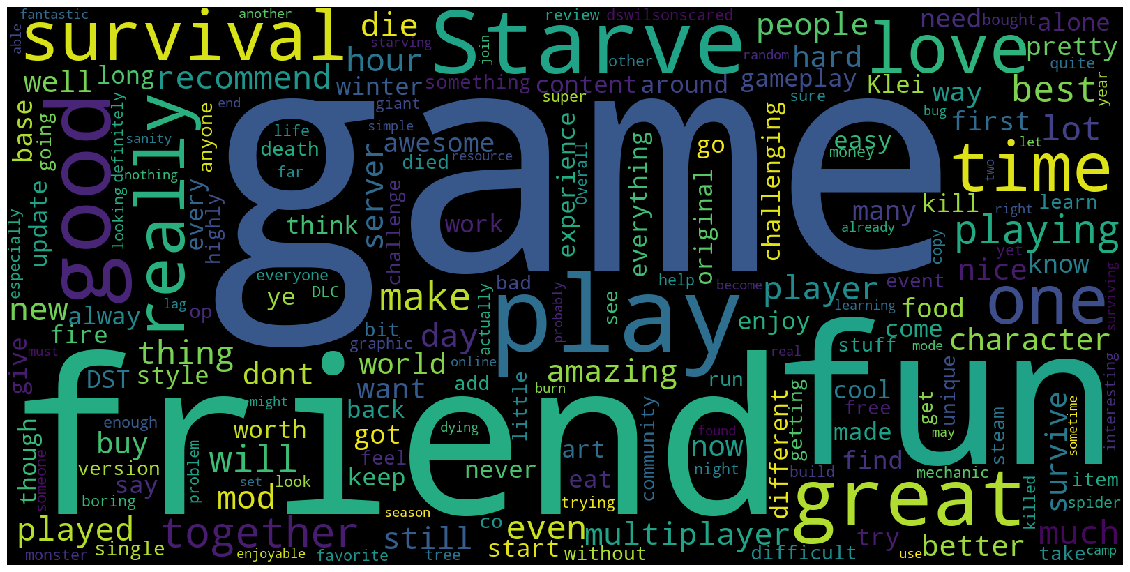

In [7]:
# wordcloud without preprocessing
corpus_string = ' '.join(corpus)
graph_word_cloud(corpus_string)

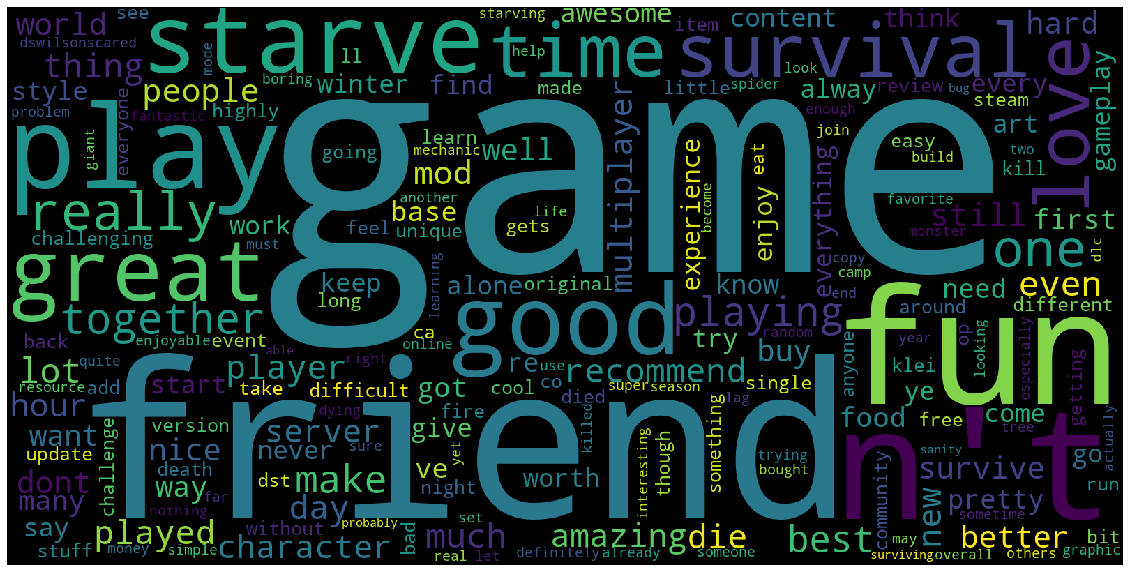

In [8]:
# wordcloud with preprocessing
preprocessed_corpus_string = ' '.join(preprocessed_corpus)
graph_word_cloud(preprocessed_corpus_string)

In [9]:
# calculate frequency and tf-idf weights for characters
characters = ["wilson", "willow", "wolfgang", "wendy", 
              "wx", "wickerbottom", "woodie", "wes", 
              "maxwell", "wigfrid", "webber", "warly", 
              "wormwood", "winona", "wortox", "wurt"]

character_frequencies = frequencies(preprocessed_corpus, characters)
character_scores = get_tfidf_scores(preprocessed_corpus, characters)

In [10]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [11]:
monsters = ["spiders", "hounds", "tentacles", "merms",  
            "bees", "frogs", "pigs", "beefalos", "rabbits",
            "beargers", "deerclops", "dragonfly"]
lemmatized_monsters = [lemmatizer.lemmatize(monster) for monster in monsters]
stemmed_monsters = [stemmer.stem(monster) for monster in monsters]
print("lemmatized:\n{0}\n".format(lemmatized_monsters))
print("stemmed:\n{0}".format(stemmed_monsters))

stemmed_data = stem_reviews(preprocessed_data)
stemmed_corpus = combine_reviews(stemmed_data)

monster_frequencies = frequencies(stemmed_corpus, stemmed_monsters)
monster_scores = get_tfidf_scores(stemmed_corpus, stemmed_monsters)

lemmatized:
['spider', 'hound', 'tentacle', 'merms', 'bee', 'frog', 'pig', 'beefalo', 'rabbit', 'beargers', 'deerclops', 'dragonfly']

stemmed:
['spider', 'hound', 'tentacl', 'merm', 'bee', 'frog', 'pig', 'beefalo', 'rabbit', 'bearger', 'deerclop', 'dragonfli']


PorterStemmer was used to normalize the preprocessed data as the WordNetLemmatizer does not correctly lemmatize words specific to Don't Starve Together.

In [12]:
seasons = ["autumn", "winters", "springs", "summers"]
stemmed_seasons = [stemmer.stem(season) for season in seasons]

season_frequencies = frequencies(stemmed_corpus, stemmed_seasons)
season_scores = get_tfidf_scores(stemmed_corpus, stemmed_seasons)

In [13]:
character_series = frequency_series("character", character_frequencies)
monster_series = frequency_series("monster", monster_frequencies)
season_series = frequency_series("season", season_frequencies)

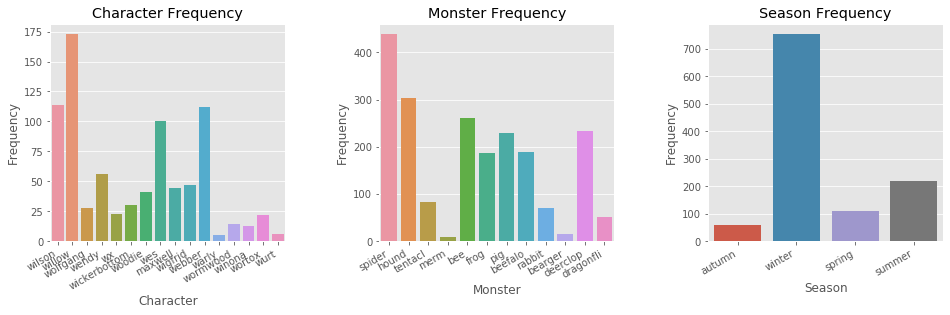

In [14]:
fig, axes = plt.subplots(ncols=3, 
                         figsize=(16, 4), 
                         squeeze=False)

fig.subplots_adjust(wspace=0.40)
axes = axes.flatten()
for axis in axes:
    plt.setp(axis.get_xticklabels(), rotation=30, ha="right")
    
character_barplot = sns.barplot(x=character_series.index, y=character_series.values, ax=axes[0])
character_barplot.set(title="Character Frequency", xlabel= "Character", ylabel="Frequency")

monster_barplot = sns.barplot(x=monster_series.index, y=monster_series.values, ax=axes[1])
monster_barplot.set(title="Monster Frequency", xlabel= "Monster", ylabel="Frequency")

season_barplot = sns.barplot(x=season_series.index, y=season_series.values, ax=axes[2])
season_barplot.set(title="Season Frequency", xlabel= "Season", ylabel="Frequency")
    
plt.show()

It is important to note that the barplot aspect ratios are NOT equal and may result in bias, affecting comparisons between different categories. On the other hand, the tf-idf scores are more suited for comparisons between words from different categories while also allowing for comparisons between words from the same category.

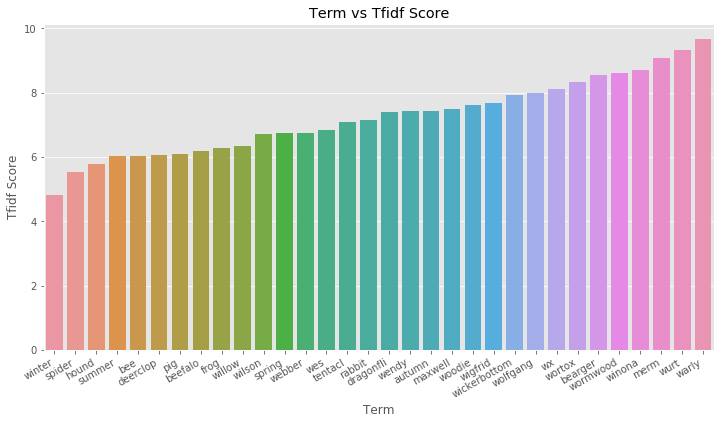

In [15]:
terms = {}
terms.update(character_scores)
terms.update(monster_scores)
terms.update(season_scores)

term_df = pd.DataFrame.from_dict(
    terms, 
    orient="index",
    columns=["tfidf_score"]
)

sorted_term_df = term_df.sort_values(by='tfidf_score', ascending=True)

plt.figure(figsize=(12, 6))
term_tfidf_barplot = sns.barplot(
    x=sorted_term_df.index, 
    y=sorted_term_df['tfidf_score']
)
term_tfidf_barplot.set(
    title="Term vs Tfidf Score",
    xlabel="Term",
    ylabel="Tfidf Score"
)
term_tfidf_barplot.set_xticklabels(
    sorted_term_df.index,
    rotation=30, 
    ha="right"
)

plt.show()